In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [91]:
def make_clusters(
        n: int = 500, 
        m: int = 2, 
        k: int = 3, 
        bounds: tuple = (-10, 10),
        scale: float = 1,
        seed: int = 42) -> (np.ndarray, np.ndarray):
    """
    creates some clustered data

    inputs:
        n: int
            number of observations
        m: int
            number of features
        k: int
            number of clusters
        bounds: tuple
            minimum and maximum bounds for cluster grid
        scale: float
            standard deviation of normal distribution
        seed: int
            random seed

    outputs:
        (np.ndarray, np.ndarray)
            returns a 2D matrix of `n` observations and `m` features that are clustered into `k` groups
            returns a 1D array of `n` size that defines the cluster origin for each observation
    """
    np.random.seed(seed)
    assert k <= n

    labels = np.sort(np.random.randint(0, k, size=n))
    centers = np.random.uniform(bounds[0], bounds[1], size=(k,m))
    mat = np.vstack([
        np.random.normal(
            loc=centers[idx], 
            scale=scale, 
            size=(np.sum(labels==idx), m))
        for idx in np.arange(0, k)])

    return mat, labels

mat_test, label_test = make_clusters(500, 2, 3, (-10, 10), 1, 42)

print(mat_test)

[[-9.34984106e+00  9.59495870e+00]
 [-9.08607065e+00  9.70123895e+00]
 [-1.07283116e+01  8.87300910e+00]
 [-9.21269147e+00  9.13578333e+00]
 [-8.55689178e+00  9.11561631e+00]
 [-1.08388577e+01  9.26004228e+00]
 [-1.05769879e+01  7.96934811e+00]
 [-1.01124181e+01  8.55730739e+00]
 [-1.12376346e+01  9.78561960e+00]
 [-1.08494251e+01  1.02388368e+01]
 [-1.08188609e+01  9.95064654e+00]
 [-9.72233065e+00  6.95230172e+00]
 [-1.07368706e+01  9.99519783e+00]
 [-9.24526052e+00  8.58999448e+00]
 [-1.19106702e+01  1.00582925e+01]
 [-7.82348530e+00  1.03567432e+01]
 [-1.03091544e+01  9.05152563e+00]
 [-9.20176816e+00  7.14127354e+00]
 [-9.51341669e+00  9.73976769e+00]
 [-8.92943096e+00  7.55756235e+00]
 [-1.05565243e+01  9.45932015e+00]
 [-9.06105676e+00  6.41456748e+00]
 [-1.21505023e+01  8.59219410e+00]
 [-1.02835621e+01  8.37042494e+00]
 [-1.01051998e+01  9.65274971e+00]
 [-9.59034111e+00  8.93636218e+00]
 [-1.10362220e+01  5.30463064e+00]
 [-8.57036741e+00  1.08119313e+01]
 [-1.00364981e+01  8

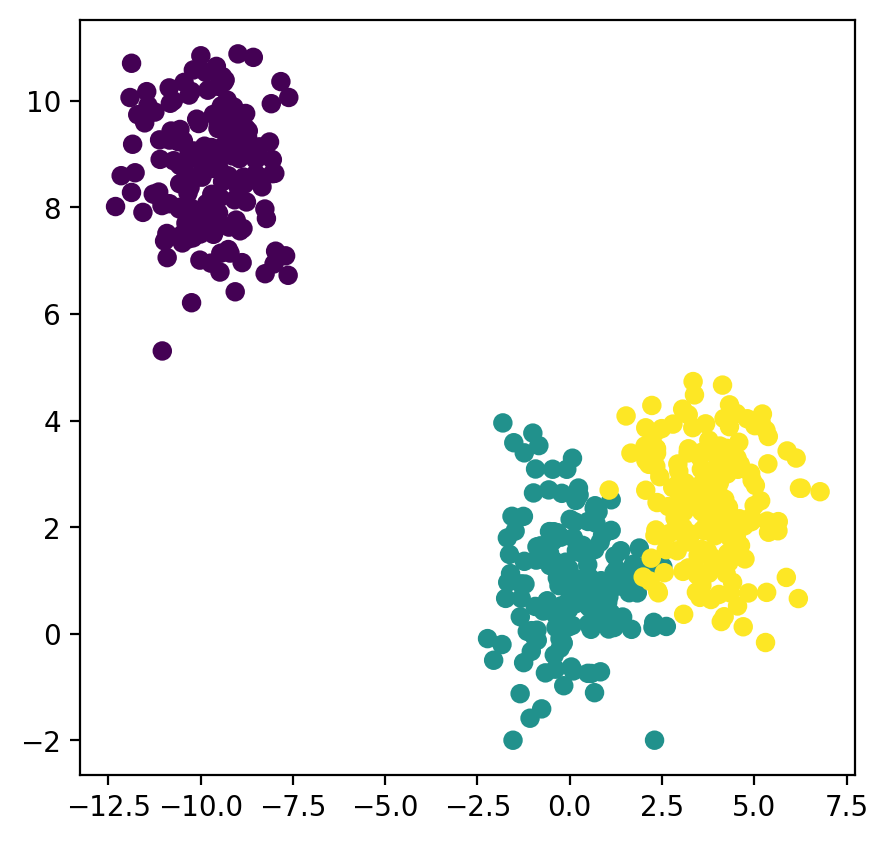

In [81]:
def plot_clusters(
        mat: np.ndarray, 
        labels: np.ndarray, 
        filename: str =None):
    """
    inputs:
        mat: np.ndarray
            a 2D matrix where each row is an observation and each column is a feature
        labels: np.ndarray
            a 1D array where each value represents an integer cluster that an observation belongs to
        filename: str
            an optional value to save a figure to a file
    """

    plt.figure(figsize=(5,5), dpi=200)
    plt.scatter(
        mat[:,0], 
        mat[:,1], 
        c=labels)

    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()
    
plot_clusters(mat_test, label_test)

In [148]:

def plot_multipanel(
        mat: np.ndarray,
        truth: np.ndarray,
        pred: np.ndarray,
        score: np.ndarray,
        filename: str = None):
    """
    Plots a multipanel figure visualizing the efficiency of truth, prediction, 
    and silhouette scoring on a provided dataset

    inputs:
        mat: np.ndarray
            a 2D matrix where each row is an observation and each column is a feature
        truth: np.ndarray
            a 1D array where each value represents a true integer cluster that an observation belongs to
        pred: np.ndarray
            a 1D array where each value represents a predicted integer cluster than an observation belongs to
        score: np.ndarray
            a 1D array where each value represents a float for the silhouette score of that observation
        filename: str
            an optional value to save a figure to a file
    """

    fig, axs = plt.subplots(1, 3, figsize=(9,3), dpi=200)
    
    cvars = [truth, pred, score]
    names = ["True Cluster Labels", "Predicted Cluster Labels", "Silhouette Scores"]
    cmaps = [None, None, "seismic"]
    for idx, ax in enumerate(axs):
        sub = ax.scatter(
            mat[:,0],
            mat[:,1],
            c=cvars[idx],
            cmap=cmaps[idx])
        ax.set_title(names[idx])
        if idx == 2:
            plt.colorbar(sub, ax=ax)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()



1.4503012126641381
-4.171662182273182


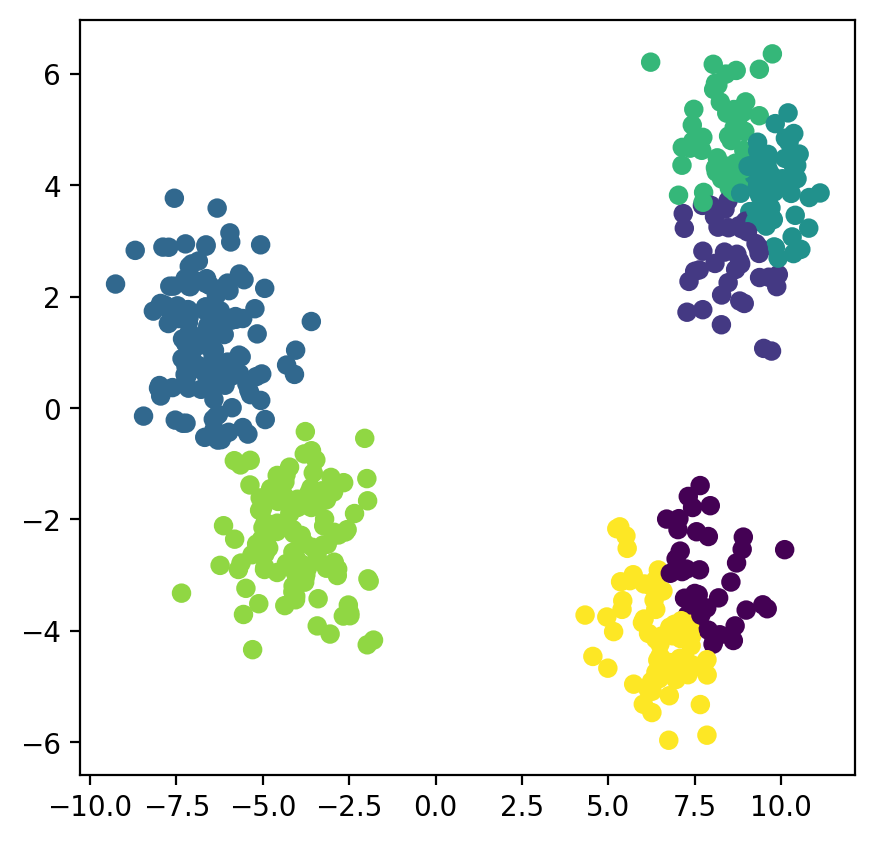

In [121]:

class KMeans:
    def __init__(
            self,
            k: int,
            metric: str = "euclidean",
            tol: float = 1e-6,
            max_iter: int = 100):
        """
        inputs:
            k: int
                the number of centroids to use in cluster fitting
            metric: str
                the name of the distance metric to use
            tol: float
                the minimum error tolerance from previous error during optimization to quit the model fit
            max_iter: int
                the maximum number of iterations before quitting model fit
        """
        self.k = k
        self.metric = metric
        self.tol = tol
        self.max_iter = max_iter
        
        # model should not run if k<=0
        if self.k<=0:
            raise ValueError("k must be greater than zero")
    
    def fit(self, mat: np.ndarray):
        """
        fits the kmeans algorithm onto a provided 2D matrix

        inputs: 
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features
        """
        
        # model should not run if k > number of observations
        if self.k > np.shape(mat)[0]:
            raise ValueError("k must be less than the number of observations in the array")

        # create random centers
        centers = np.random.uniform(np.min(mat), np.max(mat), size=(self.k,2))
        
        # set baseline values
        i=1
        mse=1
        mse_diff=1
        
        # iteratively select new centers
        while i<self.max_iter and mse_diff>self.tol:  
            # assign points to each cluster based on their distance to the centers
            dist_mat = cdist(mat, centers, metric=self.metric) # calculate distances from each point to each center, using supplied metric
            calc_labels = np.argmin(dist_mat, axis=1) # find index of minmum value in each row
            
            # calculate error - calculate squared distance from each point to its corresponding centroid, 
            # using the supplied metric, then take the mean of those values
            old_mse = mse
            mse = np.mean(np.square(np.choose(calc_labels, dist_mat.T))) # numpy.choose which constructs an array from an index array - https://stackoverflow.com/questions/17074422/select-one-element-in-each-row-of-a-numpy-array-by-column-indices
            mse_diff = abs(old_mse-mse)
            
            # update centers based on cluster membership of datapoints
            centers = np.array([mat[calc_labels==j].mean(0) for j in range(self.k)])
            
            # increment
            i+=1
        
        # store centers, labels, and final mse
        self.centers = centers
        self.labels = calc_labels
        self.mse = mse
        
    def predict(self, mat: np.ndarray) -> np.ndarray:
        """
        predicts the cluster labels for a provided 2D matrix

        inputs: 
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features

        outputs:
            np.ndarray
                a 1D array with the cluster label for each of the observations in `mat`
        """
        return self.labels

    def get_error(self) -> float:
        """
        returns the final squared-mean error of the fit model

        outputs:
            float
                the squared-mean error of the fit model
        """
        return self.mse

    def get_centroids(self) -> np.ndarray:
        """
        returns the centroid locations of the fit model

        outputs:
            np.ndarray
                a `k x m` 2D matrix representing the cluster centroids of the fit model
        """
        return self.centers

clusters, labels = make_clusters(k=4, scale=1)
km = KMeans(k=7)
km.fit(clusters)
labels = km.predict(clusters)
print(km.get_error())
print(km.get_centroids()[6,1])

plot_clusters(clusters, labels)

In [141]:
a=[[0,3], [1,3], [2,7]]
b=[[4,0],[4,0]]
c=[3,5,1,5]
#cdist(a,b)
np.argmin(b, axis=1)
np.shape(a)

(3, 2)

In [37]:
rseed=2
n_clusters=3
X=clusters
rng = np.random.RandomState(rseed)
i = rng.permutation(X.shape[0])[:n_clusters]
centers = X[i]
i

array([129, 280, 440])

In [50]:
a=5
old_a=a
a=6
print(a)
print(old_a)

6
5


In [146]:
class Silhouette:
    def __init__(self, metric: str = "euclidean"):
        """
        inputs:
            metric: str
                the name of the distance metric to use
        """
        self.metric = metric

    def score(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        calculates the silhouette score for each of the observations

        inputs:
            X: np.ndarray
                A 2D matrix where the rows are observations and columns are features. 

            y: np.ndarray
                a 1D array representing the cluster labels for each of the observations in `X`

        outputs:
            np.ndarray
                a 1D array with the silhouette scores for each of the observations in `X`
        """
        # calculate distances between all points
        dists = cdist(X, X, metric=self.metric)
        
        # count observations
        num_obs = np.shape(y)[0]
        
        # create empty 1d array for scores
        scores = np.empty(shape=(num_obs,1))
        
        # calculate score for each observation
        for obs in range(num_obs): 
            
            # determine cluster membership and calculate mean in cluster distance from obs
            curr_cluster = y[obs]
            in_cluster = np.where(y==curr_cluster)[0] # indices of observations in the cluster
            out_of_cluster = np.where(y!=curr_cluster)[0] # indices of observations outside the cluster 
            a = np.mean([dists[obs, other] for other in in_cluster if not obs==other])
            
            # calculate mean nearest cluster distance from obs
            b = np.min([np.mean([dists[obs, other] for other in out_of_cluster]) for cluster in set(y) if not cluster==curr_cluster]) ## need to make nearest cluster
            
            # calculate silhouette distance
            scores[obs] = (b-a)/max(b,a)
        
        return scores

sil=Silhouette()
sil.score(clusters, labels)

array([[0.85916639],
       [0.84904649],
       [0.86584363],
       [0.80877064],
       [0.81903909],
       [0.86349291],
       [0.67439012],
       [0.82722261],
       [0.83881275],
       [0.85830615],
       [0.86448522],
       [0.87441159],
       [0.70045283],
       [0.80926165],
       [0.8350733 ],
       [0.85269515],
       [0.85096727],
       [0.86486169],
       [0.87198735],
       [0.74268613],
       [0.78905514],
       [0.84431767],
       [0.86453874],
       [0.84707909],
       [0.84265057],
       [0.86442968],
       [0.78666815],
       [0.81355811],
       [0.72650173],
       [0.82246874],
       [0.82629493],
       [0.85390994],
       [0.85858113],
       [0.71024465],
       [0.84134904],
       [0.77323078],
       [0.8750954 ],
       [0.78524286],
       [0.84238337],
       [0.84740873],
       [0.87295773],
       [0.87868636],
       [0.86512063],
       [0.78515295],
       [0.71064128],
       [0.86818067],
       [0.87120804],
       [0.874

In [129]:
clusters[2]

array([-3.7532348, -1.7372609])

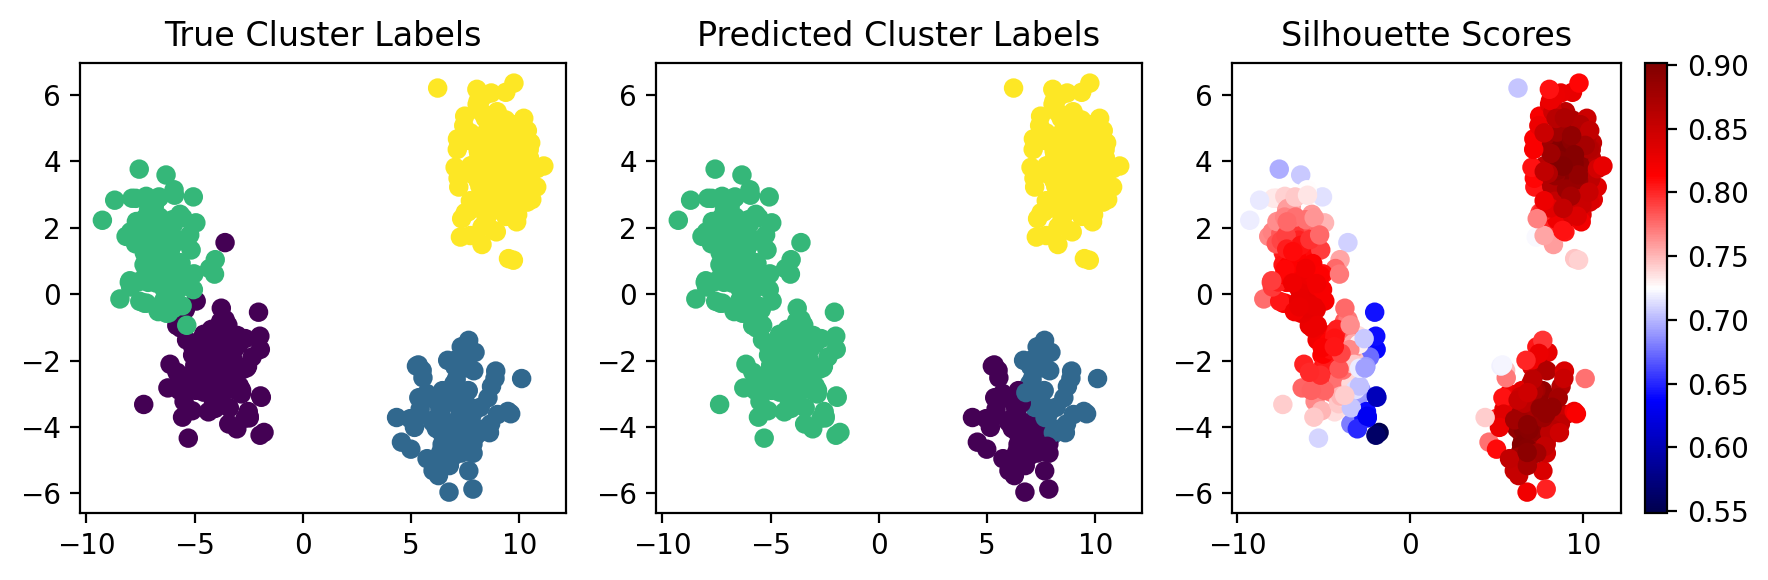

In [149]:
clusters, labels = make_clusters(k=4, scale=1)
km = KMeans(k=4)
km.fit(clusters)
pred = km.predict(clusters)
scores = Silhouette().score(clusters, pred)
plot_multipanel(clusters, labels, pred, scores)